# Who has a voice in the media?

## 1. Pre-processing the dataset
To start with, we remove the rows of the dataset where either the author or the quotation is NaN. In addition, we remove the authors who probability is lower than 50%. As our whole analysis of "who has a voice in the media" is all about the speaker and what it has said, it makes no sense to take these rows into account.

Later, we also do a sanity controll and remove possible duplicate of rows with the same quote-ID as we obiously don't want to use exactly the same quote more than once in our analyzes. 

Finally, to reduce the dataset further we remove columns that we will not use for our analysis: _quoteID_, _speaker_, _probas_, _urls_, _phase_ and _numOccurrences_.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from timeit import default_timer as timer
from collections import Counter
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.entity import WikidataItem
from pathlib import Path

##### some helpful things for data management...

In [109]:
datafolder = Path("data")

DATA = {
    '2015': datafolder / Path("clean-quotes-2015.bz2"),
    '2016': datafolder / Path("clean-quotes-2016.bz2"),
    '2017': datafolder / Path("clean-quotes-2017.bz2"),
    '2018': datafolder / Path("clean-quotes-2018.bz2"),
    '2019': datafolder / Path("clean-quotes-2019.bz2"),
    '2020': datafolder / Path("clean-quotes-2020.bz2"),
}

ALL_YEARS = ["2015","2016","2017","2018","2019","2020"]

def load_dev_data(year):
    if DATA[year].exists():
        return pd.read_csv(DATA[year], compression='bz2').sample(n=100_000, random_state=1)
    else:
        return None 
    
author_attributes = pd.read_parquet('data/speaker_attributes.parquet')
author_attributes.set_index('id', inplace=True)

In [6]:
def clean_data(chunk, thresh=0.5):
    
    # Drop duplicate quoteIDs
    nr_rows = chunk.shape[0]
    chunk = chunk.drop_duplicates(subset=['quoteID'])
    print('- Dropped {} duplicate rows with same quoteID;'.format(nr_rows - chunk.shape[0]))
    
    # Drop quotes where either speaker or quotation is None
    nr_rows = chunk.shape[0]
    chunk.replace(to_replace=['None'], value=np.nan, inplace=True)
    chunk = chunk.dropna(axis=0, subset=['speaker', 'quotation'])
    print('- Dropped {} rows with NaN speaker or quotation;'.format(nr_rows - chunk.shape[0]))
    
    # Drop rows where speakers has probability less than 50%
    nr_rows = chunk.shape[0]
    prob_filter = pd.Series([(float(chunk.iloc[i].probas[0][1]) > thresh) for i in range(nr_rows)])
    prob_filter = pd.Series(prob_filter)
    chunk = chunk[prob_filter.values]
    print('- Dropped {} rows with speaker prob smaller than 50%;'.format(nr_rows - chunk.shape[0]))
    
    # Remove columns we don't care about
    chunk = chunk.drop(columns=['quoteID', 'speaker', 'probas', 'urls', 'phase', 'numOccurrences'])

    return chunk

start_of_all = timer()
read_from_file = 'data/quotes-2016.json.bz2'
write_to_file = 'data/clean-quotes-2016.bz2'
with pd.read_json(read_from_file, lines=True, compression='bz2', chunksize=1_000_000) as df_reader:
    print('Started to process chunks...')
    i = 0
    for chunk in df_reader:
        print('\nProcessing new chunk...')
        start = timer()
        processed_chunk = clean_data(chunk)
        processed_chunk.to_csv(write_to_file, compression='bz2', mode='a', index=False)
        end = timer()
        print('Done processing and saving chunk after {:.3f} seconds.'.format(end - start))
        
end_of_all = timer()
print('\nDONE processing all chunks and saving as csv after {:.3f} minutes.'.format((end_of_all - start_of_all) / 60))
print('THE END!')

Started to process chunks...


ValueError: Expected object or value

#### Short discussion
Around one third of the original dataset has either a NaN quotation field, a NaN speaker, or a speaker with lower than 50% probability of having said that quote. Another one third of the original data is removed by the removal of the unwanted columns. Thus we are left with one third of the original dataset and still with full possibility of doing the wanted analysis

Elsemore, it seems like there are no duplicates of quote-IDs in the dataset.

## 2. Initial analyzes
Here, we do initial studies on the dataset. For instance we plot the following information about the speakers:
- gender;
- age;
- ethnicity;
- profession.

Also, we do analyzes on the content of the quotes.

In [110]:
df = load_dev_data('2020')

### Occupation
In this part of our initial analysis, we discover the distribution of occupations among the quoted speakers for the year of 2020. This can easily be extended to other years as well.

In [111]:
# Get the unique qids from the quotations df, we don't want to count the same speaker more than once:
unique_qids = df.qids.unique().tolist()

# Out of unique_qids, keep the qids of unambiguous authors whose qid exists in the parquet file:
wanted_qids = [eval(qid)[0] for qid in unique_qids if len(eval(qid)) == 1 and eval(qid)[0] in author_attributes.index]

# Get the rows of the authors having the wanted qids
authors = author_attributes.loc[wanted_qids]

# Get the authors occupations and count them
occupation_ids = [occ_id[0] for occ_id in authors.occupation.values if not occ_id is None]
occupation_count = Counter(occupation_ids)
occupation_count_sorted = dict(sorted(occupation_count.items(), key=lambda x: x[1], reverse=True)) 
top_50_occupations = dict(itertools.islice(occupation_count.items(), 50)) 
top_50_occupations_sorted = dict(sorted(top_50_occupations.items(), key=lambda x: x[1], reverse=True))
#Query wikidata for occupation labels
top_50_occupations_labels = [get_entity_dict_from_api(item)['labels']['en']['value'] for item in top_50_occupations_sorted.keys()]



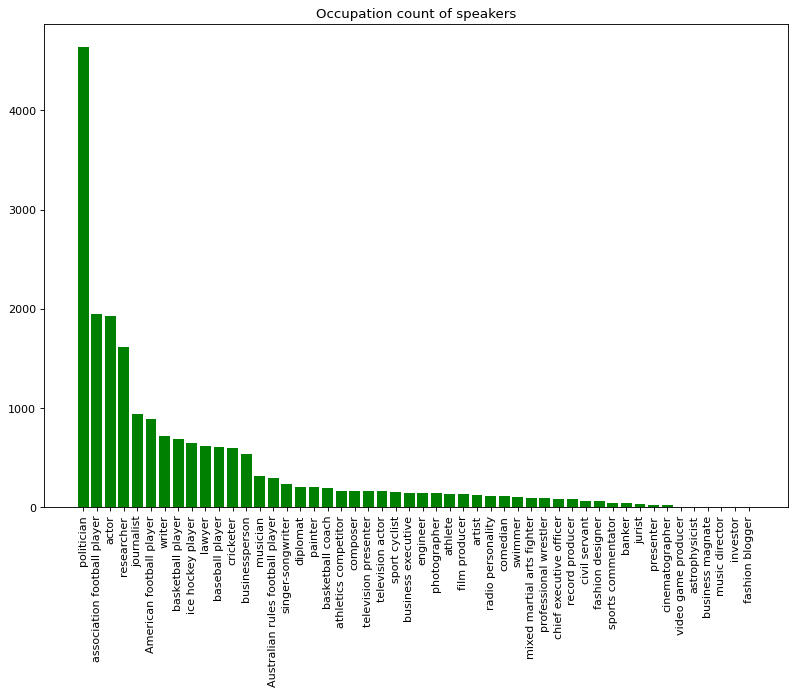

In [113]:
# Plot 
_ = plt.figure(figsize=(12, 8), dpi=80)
_ = plt.title('Occupation count of speakers')
_ = plt.bar(top_50_occupations_sorted.keys(), top_50_occupations_sorted.values(), color='g')
_ = plt.xticks(range(len(top_50_occupations_sorted)), top_50_occupations_labels, rotation=90)

#### Occupation - short discussion
We see that the greater number of quoted speakers are politicians, followed by football players, actors, researchers, journalists, etc.

### Gender

In [94]:
def count_genders(df):
        ids = [eval(id)[0] for id in df.qids.tolist() if id and eval(id)[0] in author_attributes.index]
        persons = author_attributes.loc[ids]
        all_genders = [item for sublist in persons.gender.tolist() if sublist is not None for item in sublist ]        
        genders = Counter(all_genders)
        return genders

Counter({'Q6581097': 82212, 'Q6581072': 16166, 'Q1052281': 72, 'Q48270': 45, 'Q18116794': 30, 'Q1097630': 12, 'Q2449503': 11, 'Q15145779': 11, 'Q12964198': 4, 'Q1984232': 3, 'Q15145778': 1, 'Q301702': 1, 'Q189125': 1})


In [96]:
res = {}
for year in ALL_YEARS:
    start = time.time()
    df = load_dev_data(year) 
    if df is None:
        print(f"warning: could not find year:{year}")
        continue    
    res[year] = count_genders(df) 
    end = time.time()
    print(f"processed year {year} in {end-start} seconds")
    


processed year 2016 in 114.86960792541504 seconds
processed year 2018 in 207.33829307556152 seconds
processed year 2019 in 162.71368718147278 seconds
processed year 2020 in 40.88758301734924 seconds


In [98]:
binary = ["Q6581072", "Q6581097"]

only_binary = {year: {gender: value for gender, value in dict(values).items() if gender in binary } for year, values in res.items()}

In [99]:
only_binary

{'2016': {'Q6581097': 82212, 'Q6581072': 16166},
 '2018': {'Q6581097': 80877, 'Q6581072': 17311},
 '2019': {'Q6581097': 79903, 'Q6581072': 18249},
 '2020': {'Q6581072': 18546, 'Q6581097': 79406}}

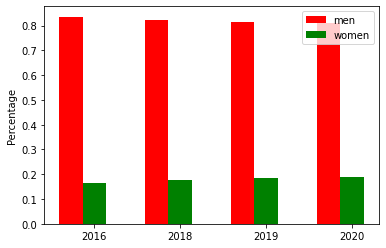

In [115]:
N = 4
ind = np.arange(N)
width = 0.27

fig = plt.figure()
ax = fig.add_subplot(111)
men = []
women = []
for key in only_binary:
    men.append(only_binary[key]['Q6581097'] / (only_binary[key]['Q6581097'] + only_binary[key]['Q6581072']))
    women.append(only_binary[key]['Q6581072'] / (only_binary[key]['Q6581097'] + only_binary[key]['Q6581072']))
    
rects1 = ax.bar(ind, men, width, color='r')
rects2 = ax.bar(ind+width, women, width, color='g')
ax.set_ylabel('Percentage')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2016', '2018', '2019', '2020') )
ax.legend( (rects1[0], rects2[0]), ('men', 'women') )
plt.show()
